In [14]:
# Value at Risk Calculations 

import numpy as np #algebra
import pandas as pd # dataframes
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

def get_data(stocks,start,end):
    stockData = yf.download(stocks, start=start, end=end) 
    stockData = stockData["Close"] #Extracts only the closing price for the data we retrieved 
    returns = stockData.pct_change() #Computes the returns over consecutive closing prices
    meanReturns = returns.mean() #Calculate the average daily return for each stock
    covMatrix = returns.cov() #Calculate the covariance matrix of the daily returns
    return meanReturns, covMatrix

# Setting up the portfolio

stockList = ["AAPL", "MSFT", "JPM", "V", "UNH", "GS", "HD",
             "PG", "DIS", "NKE", "AXP", "IBM", "MMM", "TRV",
             "CVX", "KO", "MRK", "PFE", "MCD", "WMT", "INTC",
             "CSCO", "VZ", "BA", "CAT", "JNJ", "WBA", "DOW", 
             "AMGN", "HON"]


# Define an end data
endDate = dt.datetime.now() # Current date
startDate = endDate - dt.timedelta(days=300) #start date is 300 days before todays date 

meanReturns, covMatrix = get_data(stockList, startDate, endDate) #Tuple unpacking - returing the (meanReturns, covMatrix) as two seperate variables

# Portfolio weights - of different allocations to the stocks in the portfolio

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  30 of 30 completed


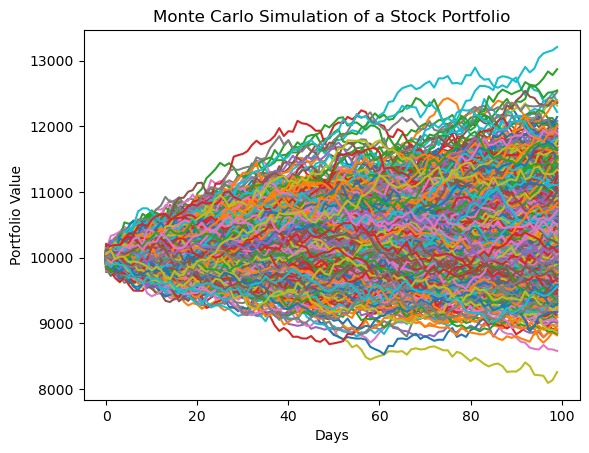

In [16]:
# Monte Carlo Method

mc_sims = 1000 # The number of simulated scenarios, representing the evolution of the portfolio
T = 100 # Number of days we simulate returns 

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns) #Creates a matrix of T by No. of stocks; each row starts with a value of mean returns.  
meanM = meanM.T # Shape now is No of stocks by T; Each Column is a single day, each row is a single stocks mean return. 

# E.g. of meanM output: 

# meanM =
# [
# [0.0012, 0.0012, 0.0012, 0.0012, ..., 0.0012],  # 100 times for AAPL if mean return is 0.0012 (0.12% per day)
# [0.0008, 0.0008, 0.0008, 0.0008, ..., 0.0008],  # 100 times for COST if mean return is 0.0008 (0.08% per day)
# [0.0015, 0.0015, 0.0015, 0.0015, ..., 0.0015]   # 100 times for MSFT if mean return is 0.0015 (0.15% per day)
#]

# Initialise an empty matrix to hold the simulation values - will have one row per day (T rows) and one column per simulation (mc_sims columns).
# Store the portfolios path from day 0 to day T 
port_sims = np.full(shape=(T, mc_sims), fill_value=0.0) 

# Create a starting point to see how the portfolio value evolves

initialPortfolio = 10000


# Assuming that daily returns are distributed by a Multivariate Normal Distribution 


for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights))) # Generate a matrix of random values drawn from a standard normal distribution. Each row is a day, each column is a stock
    L = np.linalg.cholesky(covMatrix) # the lower-triangular matrix resulting from the Cholesky decomposition of the covariance matrix. Transformation Matrix

    # Assuming that daily returns are given by the mean + random value which includes correlations, ensuring that the simulated daily returns reflect not just individual stock volatilities, but also how stocks move in relation to each other.
    
    dailyReturns = meanM + np.inner(L, Z) # When we multiply L by Z it converts these independent random draws into correlated random draws.

    # port_sims[:, m] - for the m^th simulation in the loop, take each row and populate it with the portfolio return (monetary value) that day. Do this for all days up to T, for every iteration m. 
    port_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio # np.inner(weights, dailyReturns.T) converts the return of the stock into the return in the portfolio based on the weights - gives total portfolio return
                                                                                      #...'+1' turns the returns into growth factors; np.cumprod() takes the cumulative product of these daily growth factors, giving the total growth of the portfolio over time. Then we multiply by the portfolio value to get monetary value


plt.plot(port_sims)
plt.ylabel("Portfolio Value")
plt.xlabel("Days")
plt.title("Monte Carlo Simulation of a Stock Portfolio")
plt.show()
    
    



In [18]:
# Value-at-Risk from Monte-Carlo

#Input: pandas series of returns
#Output: percentile on returns distribution to a given confidence level alpha

def mcVar(returns, alpha=5): 
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a Pandas Data Series")
    
# Conditional Value at risk - Expected Shortfall below the percentile

#Input: pandas series of returns 
#Output: CVaR or Expected Shortfall to a given confidence level alpha

def mcCVar(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVar = returns <= mcVar(returns, alpha=alpha)
        return returns[belowVar].mean()
    else:
        raise TypeError("Expected a Pandas Data Series")


# Return MC simulations at very last time step

portResults = pd.Series(port_sims[-1,:]) #All the columns but for the last row

portValue_VaR = initialPortfolio - mcVar(portResults, alpha=5)
portValue_CVaR = initialPortfolio - mcCVar(portResults, alpha=5)

print(f"The lowest value of the portfolio with 95% confidence = ${portValue_VaR.round(2)}. Meaning we expect to experience a maximum loss of {(mcVar(portResults, alpha=5)).round(2)} from our portfolio value with 95% confidence" )
print(f"The (expected) lowest value of the portfolio if returns are in the worst 5% of cases = ${portValue_CVaR.round(2)}")




The lowest value of the portfolio with 95% confidence = $630.84. Meaning we expect to experience a maximum loss of 9369.16 from our portfolio value with 95% confidence
The (expected) lowest value of the portfolio if returns are in the worst 5% of cases = $880.74


In [36]:
# Value at Risk - Via Quantile Regression (Linear Approach)

Whilst we have estimated the VaR above based on the Monte-Carlo, the VaR is not based on the true returns data. To be able to find VaR with the true returns data, let's look back at VaR which can be defined as:

$$
VaR_{t}(X) = \inf \{x \mid F_{X}(x) \geq \tau\} = F_{X}^{-1}(\tau)
$$

Where $ \tau $ is the specified confidence level, and X is a vector of returns. With such an expression, it's easy to see that this is the same as saying VaR is the $ \tau^{th} $ quantile of the returns distribution X. 

Quantile Regression (Koenker & Bassett Jr, 1978) provides a framework where we can obtain the quantiles of a distribution without requiring any of the classical assumptions. This will work well for financial data, which frequently possesses heavy tails. 

For our QR model, the explanatory variables that we will use will be the estimated volatility forecasts and different holding periods. Based on the research of Chen & Chen (2002), we will consider three different volatility models: 

$$
\begin{enumerate}
    \item GARCH
    \item EWMA
    \item t-GARCH
\end{enumerate}
$$

